In [18]:
## IMPORT ##

import sys
import glob
import os
import json
from os import listdir
from os.path import isfile, join

from collections import defaultdict,Counter
import math

import pandas as pd
#import plotly as py
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# vcf parser and associated utilities
# VariantFile is the the pysam vcf file handler returning a pysam vcf record
from pysam import VariantFile
from pybedtools import BedTool, create_interval_from_list

#Fot the http request to jvenn
from IPython.display import display, HTML
#py.offline.init_notebook_mode(connected=True)



In [19]:
## FUNCTIONS ##
def loadSVfromDetectionDirectories(sv_type, directory, extension='vcf.gz', size_min=0, size_max=0, verbose=False):
    records = defaultdict()
    for sv in sv_type:
        records[sv]=[]

    #print(sv_type, directories, extension, size_min, size_max)
    for sv in sv_type:
        sv_dir = directory + "/" + sv + "/"            
        try:
            variant_files = [f for f in listdir(sv_dir) if isfile(join(sv_dir, f))]
        except FileNotFoundError:
            print("Directory not Found : ",join(sv_dir))
            continue
            
        for file in variant_files:
            if file.endswith(extension):
                try:
                    sv_in = VariantFile(join(sv_dir,file))
                except ValueError:
                    print("Incorrect format for file : ",join(sv_dir,file))

                for r in sv_in:
                    sv_size = r.stop - r.start + 1
                    if (size_min == 0 and size_max == 0) or (sv_size>=size_min and sv_size<=size_max):
                        records[sv].append(r)
    if verbose:                    
        print("SV_TYPE : ",sv_type)
        print("Number of variant for each SV_TYPE : ")
        for sv in sv_type:
            print("   ",sv,len(records[sv]))
                        
    return records

def getDetectedRecordsId(record,sv_type,tools):
    detected_all = defaultdict(list)
    #Initialisation
    for sv in sv_type:
        detected_all[sv]=defaultdict(list)
        for t in tools:
            detected_all[sv][t]=[]
            
    for sv in sv_type:
        for t in tools:
            for r in record[sv][t]:
                detected_all[sv][t].append(r.id)
    return detected_all


def formatDetectedVariant(record,sv_type,tools,verbose=True):
    detected_all = defaultdict(list)
    #Initialisation
    for sv in sv_type:
        detected_all[sv]=defaultdict(list)
        for t in tools:
            detected_all[sv][t]=[]
    
    for sv in sv_type:
        for r in record[sv]:
            tool_name = r.id.split('_')[0]
            if tool_name not in tools:
                print('Unsupported tool results',tool_name)
                continue
            else:
                detected_all[sv][tool_name].append(r)
                
            if (len(r.filter)==0) or ((len(r.filter) == 1) and ('PASS' in r.filter)):
                detected_all[sv]['PASS'].append(r)
                

    if verbose:
        print("Tools results detected : ",tools)    
        print("Number of variant DETECTED for each SV_TYPE : ")
        for t in tools:
            print("   ",t,":")
            for sv in sv_type:
                print("       ",sv,":",len(detected_all[sv][t]))
    return detected_all

def initFormattedRecord(sv_type,tools):
    record = defaultdict(list)
    for sv in sv_type:
        record[sv]=defaultdict(list)
        for t in tools:
            record[sv][t]=[]
    return record

def getFormattedRecordBySize(record,sv_type,tools,min_size,max_size):
    size_record = initFormattedRecord(sv_type,tools)
    for sv in sv_type:
        for t in tools:
            for r in record[sv][t]:
                if min_size <= abs(r.stop-r.start)+1 < max_size:
                    size_record[sv][t].append(r)
    return size_record
    
    

def getNumbersFromFormattedRecord(record,sv_type,tools,min_size=0, max_size=0):
    
    number_record = initFormattedRecord(sv_type,tools)
    
    for sv in sv_type:
        for t in tools:
            number_record[sv][t]=defaultdict(list)
            number_record[sv][t]['PASS']=0
            number_record[sv][t]['DUPLICATE']=0
            number_record[sv][t]['FILTEREDOUT']=0
            
    if (max_size > 0) and (min_size < max_size):
        record = getFormattedRecordBySize(record,sv_type,tools,min_size,max_size)
        
    for sv in sv_type:
        for t in tools:
            if t == 'PASS':
                number_record[sv][t]['PASS'] = len(record[sv][t])
                number_record[sv][t]['DUPLICATE'] = 0
                number_record[sv][t]['FILTEREDOUT'] = 0
            else:
                for r in record[sv][t]:
                    if (len(r.filter)==0) or ((len(r.filter) == 1) and ('PASS' in r.filter)):
                        number_record[sv][t]['PASS']+=1
                    elif len(r.filter)==1 and 'DUPLICATE' in r.filter:
                        number_record[sv][t]['DUPLICATE'] +=1
                    else:
                        number_record[sv][t]['FILTEREDOUT'] +=1
    
    return number_record
    
def getDataFrame(record,sv_type,tools):
    data=[]
    for sv in sv_type:
        data_tool=[]
        for t in tools:
            data_tool.append(len(record[sv][t]))
        data.append(data_tool)
    return data

In [20]:
## VARIABLES ##
sv_type=['INV','DEL','DUP']
#species=['bee','chicken','goat','poplar','human','zea']
tools=['PASS','pindel','delly','lumpy','genomestrip']
detection_dir="../batch001/filtered/"
tools_color=['#3498db','#e74c3c','#1abc9c','#f39c12','#9b59b6']
#tools_color=['#3498db','#e74c3c','#1abc9c','#f39c12','#9b59b6']
size_interval=[(0,200),(200,500),(500,1000),(1000,10000),(10000,50000),(50000,2000000)]
size_interval_name=["0-200","200-500","500-1k","1k-10k","10k-50k","50k+"]

In [21]:
## Load SV ##
sv_records = defaultdict()
sv_records=loadSVfromDetectionDirectories(sv_type,detection_dir)
formatted_records = formatDetectedVariant(sv_records,sv_type,tools,verbose=False)

               
## SV stat by tool ##
#table



In [22]:
def table2htmlstr(data,table_title,column_header,row_header):
    html_table_str=""
    table_style = "style=\"font-size: 16px;border:none\""
    column_header_style = "style=\"background-color:midnightblue; color:white; font-size: 20px;\""
    row_header_style = "style=\"text-align:center;font-size: 20px;\""
    
    cell_width = str(int(100/(len(column_header)+1)))+"%"

    html_table_str = "<font size=5>"+table_title+"</font>"
    html_table_str += "<table "+table_style+">"
    html_table_str += "<tr "+column_header_style+"><td width="+cell_width+"></td>"
    for t in tools:
        html_table_str += "<td width="+cell_width+">"+t+"</td>"
    html_table_str += "</tr>"

    for sv in sv_type:
        html_table_str +="<tr><td "+row_header_style+">"+sv+"</td>"
        for t in tools:
            html_table_str += "<td>"+str(data[sv][t])+"</td>"
        html_table_str +="</tr>"
    html_table_str +='</table>'
    
    return html_table_str


tools=['pindel','delly','lumpy','genomestrip','combined']
numbers = defaultdict()
for sv in sv_type:
    if sv not in numbers:
        numbers[sv] = defaultdict()
    numbers[sv]['combined']=0
    for t in tools:
        if t != 'combined':
            numbers[sv][t] = len(formatted_records[sv][t])
            for r in formatted_records[sv][t]:
                if "DUPLICATE" not in r.filter:
                    numbers[sv]['combined']+=1
#print(numbers)
html_table_str = table2htmlstr(numbers,"Number of raw SV found by tool",tools,sv)
display(HTML(html_table_str))


In [23]:
#print(numbers)
numbers = defaultdict()
for sv in sv_type:
    if sv not in numbers:
        numbers[sv] = defaultdict()
    numbers[sv]['combined']=0
    for t in tools:
        if t != 'combined':
            numbers[sv][t]=0
            for r in formatted_records[sv][t]:
                if (len(r.filter)==0) or ((len(r.filter) == 1) and ('PASS' in r.filter)) or ((len(r.filter) == 1) and ('DUPLICATE' in r.filter)):
                    numbers[sv][t]+=1
                    if len(r.filter)==0 or ((len(r.filter) == 1) and ('PASS' in r.filter)):
                        numbers[sv]['combined']+=1
#print(numbers)
html_table_str = table2htmlstr(numbers,"Number of filtered SV found by tool",tools,sv)
display(HTML(html_table_str))
                    

#display(HTML('<table><tr><td></td><td>Column 1</td><td>Column 2</td></tr><tr><td>Row 1</td><td>value 1</td><td>value 2</td></tr><tr><td>Row 2</td><td>value 3</td><td>value 4</td></tr></table>'))


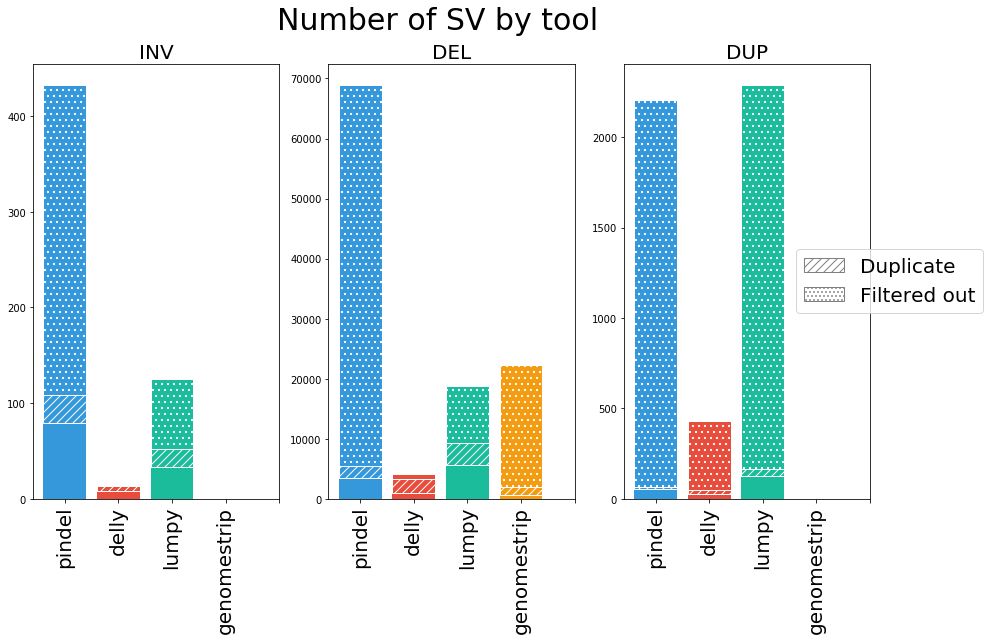

In [24]:
tools=['pindel','delly','lumpy','genomestrip']
## SV stat by tool ##
#graph
variant_number = getNumbersFromFormattedRecord(formatted_records,sv_type,tools)


#print(variant_number)

f,axarr = plt.subplots(1,3,sharex=False,sharey=False,figsize=(15,8))
index=-1
for sv in sv_type:
    index += 1
    data_pass=[]
    data_duplicate=[]
    data_filteredout=[]
    for t in tools:
        data_pass.append(variant_number[sv][t]['PASS'])
        data_duplicate.append(variant_number[sv][t]['DUPLICATE']) 
        data_filteredout.append(variant_number[sv][t]['FILTEREDOUT'])
    
    axarr[index].bar(tools,data_pass,color=tools_color)
    axarr[index].bar(tools,data_duplicate,bottom = data_pass,color=tools_color,hatch='///',edgecolor='white')
    axarr[index].bar(tools,data_filteredout,bottom = [x+y for x, y in zip(data_pass,data_duplicate)],color=tools_color,hatch='..',edgecolor='white')
    axarr[index].set_title(sv,fontsize=20)
    
a_val = 1
l1 = mpatches.Patch( edgecolor='grey', facecolor='white',alpha=a_val,label='Duplicate',hatch='r///')
l2 = mpatches.Patch( edgecolor='grey', facecolor='white',alpha=a_val,label='Filtered out',hatch='r...')
plt.legend(handles = [l1,l2],loc="right",fontsize=20, bbox_to_anchor=(1.5,0.5))
f.suptitle("Number of SV by tool",fontsize=30)

for ax in f.axes:
    plt.sca(ax)
    plt.xticks(range(0,len(tools)+1),tools,rotation=90,fontsize=20)

plt.show()

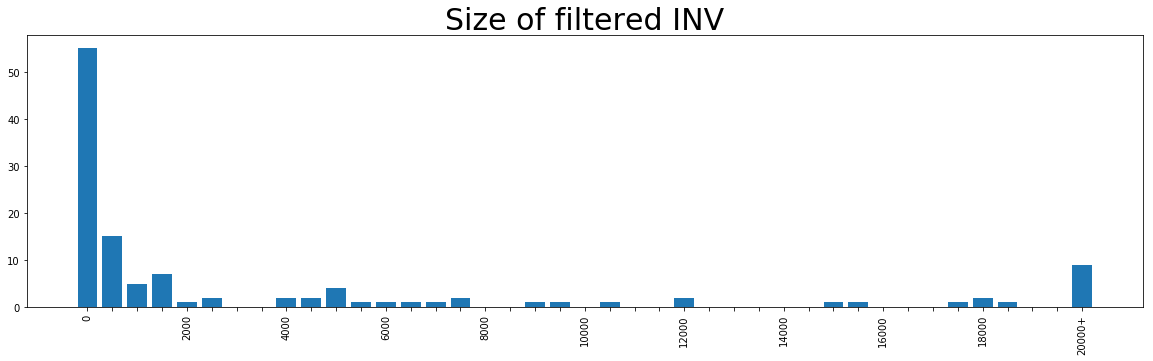

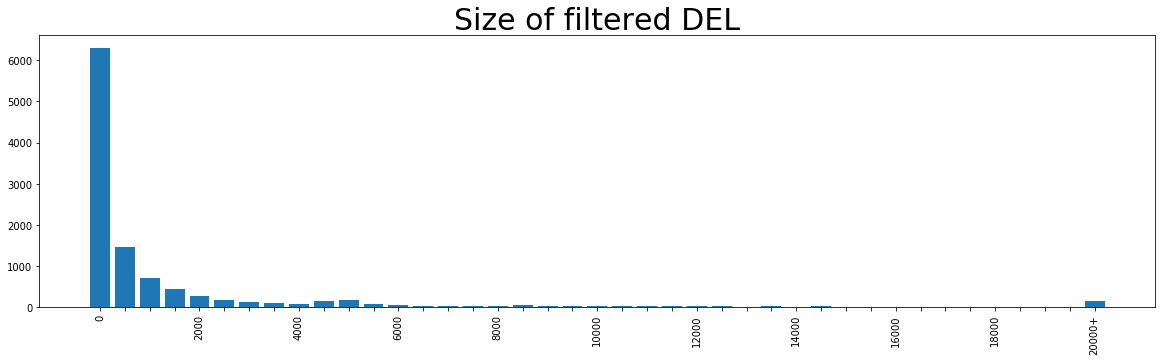

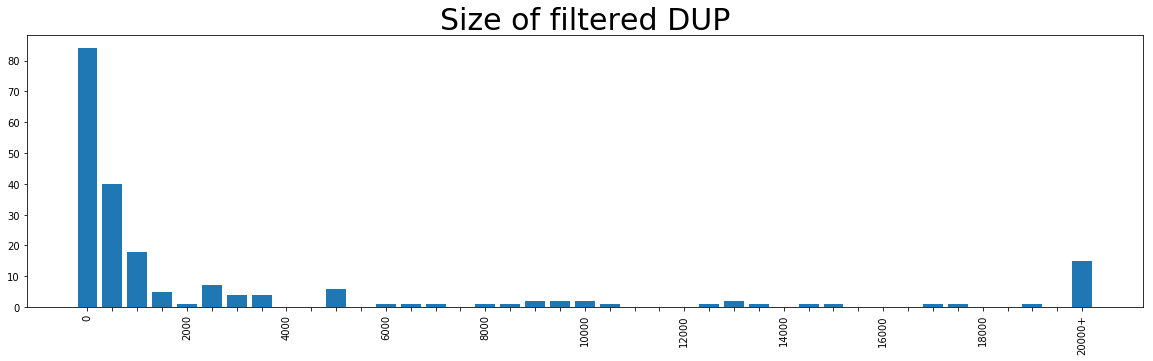

In [25]:
### Graph des effectifs des sv en fonction de leur taille
tools=['PASS','pindel','delly','lumpy','genomestrip']

def getSizeForDisplay(sv_type,tools,formatted_records):
    sv_size=defaultdict()
    for sv in sv_type:
        for t in tools:
            if t not in sv_size.keys():
                sv_size[t]=defaultdict(list)
            sv_size[t][sv]=[]

            for r in formatted_records[sv][t]:
                sv_size[t][sv].append(r.stop-r.start+1)
    return sv_size

sv_size = getSizeForDisplay(sv_type,tools,formatted_records)


def buildIntervalEffectifFromList(data,start,stop,step,all=True):
    nb_in_interval=[]
    interval=[]
    for bin in [range(i, i+step) for i in range(start, stop, step)]:
        str_interval = str(min(bin))
        interval.append(str_interval)
        nb=0
        for size in data:
            if size in bin:
                nb+=1
        nb_in_interval.append(nb)
    #The remaining values
    if all:
        max_value=max(data)
        interval.append(str(stop)+"+")
        nb=0
        for size in data:
            if size in range(stop+1,max_value):
                nb+=1
        nb_in_interval.append(nb)    
    return interval,nb_in_interval

start=0
stop=20000
step=500

for sv in sv_type:
    interval,nb_in_interval = buildIntervalEffectifFromList(sv_size['PASS'][sv],start,stop,step,True)
    #print(interval)

    plt.figure(figsize=(20,5))
    #plt.grid(None)
    plt.bar(interval,nb_in_interval)
    plt.xticks(range(0,len(interval)),interval,rotation=90,fontsize=10)

    ax = plt.gca()
    labels = [item.get_text() for item in ax.get_xticklabels()]

    nb=1
    formatted_labels=[]
    padding = int((stop / step) / 10)
    for l in labels:
        if (nb == 1) or (nb == len(labels)) or ((nb -1)  % padding == 0):
            formatted_labels.append(l)
        else :
            formatted_labels.append("")
        nb+=1

    #print (formatted_labels)

    ax.set_xticklabels(formatted_labels)

    plt.title("Size of filtered " + sv,fontsize=30)

    #plt.xticks(range(0,len(graph_species)),graph_species,rotation=90,fontsize=20)
    #plt.axis('off')
    plt.show()